In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os

In [2]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

0.34.1


In [3]:
import rasterio
import numpy as np
import glob
import os

## Directory where rasters are stored
# raster_dir = "F:\\Biomass tiffs\\Output\\Clippy"

#Updated: 08/05/2025 - to reflect 'final' model
# raster_dir = "F:/Biomass tiffs/Biomass modeling/Georgia/Georgia model only/GEE_Exports"
raster_dir = "F:/Biomass tiffs/Biomass modeling/Georgia/Georgia model only/log_model"

raster_files = sorted(glob.glob(os.path.join(raster_dir, "*.tif")))

# Optionally extract years from filenames
# years = [int(os.path.basename(f)[4:8]) for f in raster_files] #For non-clipped output
years = [int(os.path.basename(f).split('_')[-1].split('.')[0]) for f in raster_files]

##ADDED
years = np.array(years)

# Load stack: shape (time, rows, cols)
stack = []
for file in raster_files:
    with rasterio.open(file) as src:
        stack.append(src.read(1).astype(np.float32))  # Ensure float for NaNs
        profile = src.profile  # Save profile from one file to write output later

stack = np.stack(stack)  # (time, rows, cols)

# Mask no-data values (assuming 0 or some other value is nodata)
stack[stack == profile['nodata']] = np.nan  # Or pick your own nodata value



    ##OLD
# # Read all rasters into a 3D array (time, rows, cols)
# stack = []
# for file in raster_files:
#     with rasterio.open(file) as src:
#         stack.append(src.read(1))  # Read first band

# stack = np.stack(stack)  # Shape: (years, rows, cols)

In [4]:
import os
import glob
import numpy as np
import rasterio
from scipy.stats import linregress

rows, cols = stack.shape[1:]
slope_array = np.full((rows, cols), np.nan, dtype=np.float32)
pval_array = np.full((rows, cols), np.nan, dtype=np.float32)

# Calculate slope + p-value per pixel
for i in range(rows):
    for j in range(cols):
        y = stack[:, i, j]
        if np.isfinite(y).sum() > 1:  # need at least 2 points
            res = linregress(years, y)
            slope_array[i, j] = res.slope
            pval_array[i, j] = res.pvalue

# Save slope raster
slope_out = "F:/Biomass tiffs/Biomass modeling/Georgia/All_trend/LOG_1984to2023.tif"
profile.update(dtype=rasterio.float32, count=1, nodata=np.nan)
with rasterio.open(slope_out, 'w', **profile) as dst:
    dst.write(slope_array, 1)

# Save significant slopes only (p < 0.05)
sig_mask = (pval_array < 0.05)
sig_slopes = np.where(sig_mask, slope_array, np.nan)
sig_out = "F:/Biomass tiffs/Biomass modeling/Georgia/All_trend/LOG_sig_1984to2023.tif"
with rasterio.open(sig_out, 'w', **profile) as dst:
    dst.write(sig_slopes, 1)

print(f"Slope map saved: {slope_out}")
print(f"Significant slope map saved: {sig_out}")


Slope map saved: F:/Biomass tiffs/Biomass modeling/Georgia/All_trend/LOG_1984to2023.tif
Significant slope map saved: F:/Biomass tiffs/Biomass modeling/Georgia/All_trend/LOG_sig_1984to2023.tif


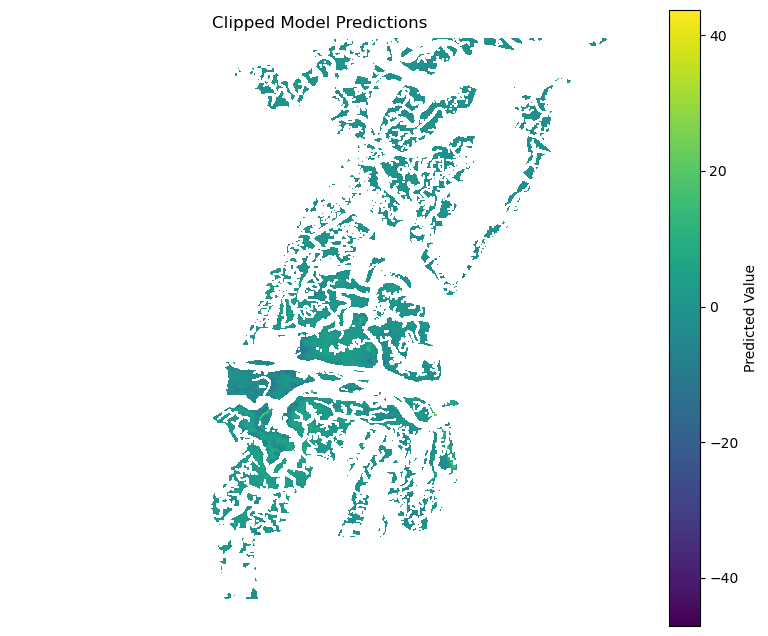

In [58]:
#Clipping to GA_estuaries file
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt

# Paths
# raster_path = out_path  OLD
raster_path = slope_out
# raster_path = sig_out
# raster_path = "F:/Biomass tiffs/Biomass modeling/Georgia/Georgia model only/GEE_Exports/abg_2023.tif"

# shapefile_path = "F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_estuaries.shp"

# Load the shapefile
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs("EPSG:4326")  # Optional: match CRS if needed

# Open the raster and clip it
with rasterio.open(raster_path) as src:
    # Ensure CRS matches
    if src.crs != gdf.crs:
        gdf = gdf.to_crs(src.crs)

    # Convert GeoDataFrame geometry to GeoJSON-like mapping
    shapes = gdf.geometry.values
    out_image, out_transform = mask(src, shapes, crop=True)
    out_meta = src.meta.copy()

# Update metadata to match clipped output
out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Plot the clipped prediction
plt.figure(figsize=(10, 8))
plt.imshow(out_image[0], cmap='viridis')
plt.colorbar(label='Predicted Value')
plt.title("Clipped Model Predictions")
plt.axis('off')
plt.show()

In [17]:
# #Export clipped image
# clipped_path = f"F:/Biomass tiffs/Biomass modeling/Georgia/All_trend/CLIPPED_TESTtrend_sig_1984to2023.tif"
# with rasterio.open(clipped_path, "w", **out_meta) as dest:
#     dest.write(out_image)

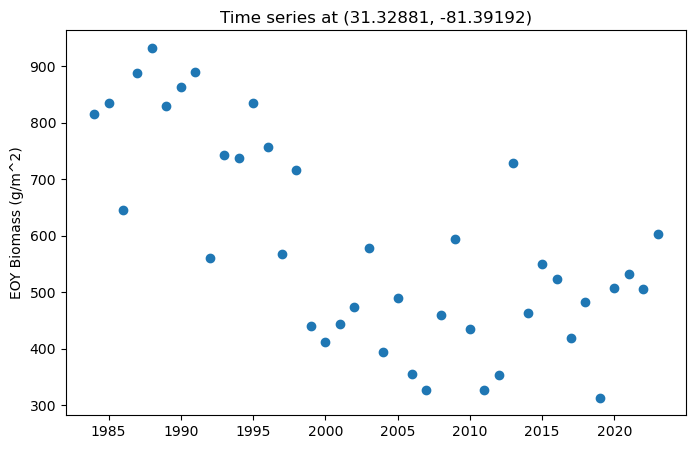

In [9]:
##Point time series visualization
from rasterio.transform import rowcol

lat, lon = 31.43, -81.29  #Negative - Airport marsh?

lat, lon = 31.32881, -81.39192  #Negative - Juncus?

# lat, lon = 31.30184, -81.28859 #Positive - accretion?

with rasterio.open(raster_files[0]) as src:
    row, col = rowcol(src.transform, lon, lat)  # note: lon first, then lat

pixel_values = stack[:, row, col]

plt.figure(figsize=(8, 5))
plt.plot(years, pixel_values, marker='o', linestyle='')
plt.xlabel("")
plt.ylabel("EOY Biomass (g/m^2)")
plt.title(f"Time series at ({lat}, {lon})")
plt.grid(False)
plt.show()

In [61]:
# #Interactive map
# import matplotlib.pyplot as plt
# from rasterio.transform import rowcol

# def interactive_pixel_timeseries(stack, years, reference_raster):
#     """
#     Click on a pixel to plot its time series.
    
#     stack: numpy array (time, rows, cols)
#     years: list or array of years
#     reference_raster: path to one of the rasters (for georeferencing)
#     """
    
#     with rasterio.open(reference_raster) as src:
#         transform = src.transform
    
#     fig, ax = plt.subplots(figsize=(10, 8))
#     img = ax.imshow(stack[0, :, :], cmap='viridis')  # show first year
#     ax.set_title("Click on a pixel to view time series")
#     plt.colorbar(img, ax=ax, label="Value")
    
#     def onclick(event):
#         if event.inaxes != ax:
#             return
        
#         # Get pixel coordinates from click
#         col, row = int(round(event.xdata)), int(round(event.ydata))
        
#         # Check bounds
#         if row < 0 or col < 0 or row >= stack.shape[1] or col >= stack.shape[2]:
#             print("Click inside the image!")
#             return
        
#         # Extract values
#         values = stack[:, row, col]
        
#         if np.isnan(values).all():
#             print(f"Pixel ({row}, {col}) has no data.")
#             return
        
#         # Plot time series
#         plt.figure(figsize=(8, 5))
#         plt.plot(years, values, marker='o')
#         plt.xlabel("Year")
#         plt.ylabel("Value")
#         plt.title(f"Time series at pixel ({row}, {col})")
#         plt.grid(True)
#         plt.show()
    
#     # Connect click event
#     cid = fig.canvas.mpl_connect('button_press_event', onclick)
#     plt.show()

# # Example usage
# interactive_pixel_timeseries(stack, years, raster_files[0])


In [ ]:
#Finito

In [8]:
# ##OLD CODE

# import sklearn
# from sklearn.linear_model import LinearRegression

# # Prepare x values (years) for regression
# X = np.array(years).reshape(-1, 1)  # shape: (n_years, 1)
# rows, cols = stack.shape[1:]

# # Initialize output array for slopes
# slope_array = np.full((rows, cols), np.nan)

# # Loop over each pixel
# for i in range(rows):
#     for j in range(cols):
#         y = stack[:, i, j]
#         if np.all(np.isfinite(y)):
#             model = LinearRegression().fit(X, y)
#             slope_array[i, j] = model.coef_[0]  # slope


In [9]:
# # out_path = "F:\\Biomass tiffs\\All_trend\\trend_2010to2023.tif"
# out_path = "F:\\Biomass tiffs\\Biomass modeling\\Georgia\\All_trend\\trend_1984to2023.tif"


# # Use metadata from one of the input files
# with rasterio.open(raster_files[0]) as src:
#     meta = src.meta.copy()

# meta.update(dtype=rasterio.float32, count=1)

# with rasterio.open(out_path, 'w', **meta) as dst:
#     dst.write(slope_array.astype(rasterio.float32), 1)

# print(f"Saved slope image to {out_path}")

Saved slope image to F:\Biomass tiffs\Biomass modeling\Georgia\All_trend\trend_1984to2023.tif
